# Homework 2, *part 1* (40 points)

This warm-up problem set is provided to help you get used to PyTorch.

Please, only fill parts marked with "`Your code here`".

In [1]:
import numpy as np
import math

import matplotlib.pyplot as plt
%matplotlib inline

import torch
assert torch.__version__ >= '1.0.0'

To learn best practices $-$ for example,

* how to choose between `.sqrt()` and `.sqrt_()`,
* when to use `.view()` and how is it different from `.reshape()`,
* which `dtype` to use,

$-$ you are expected to google a lot, read tutorials on the Web and study documentation.

Quick documentation on functions and modules is available with `?` and `help()`, like so:

In [2]:
help(torch.sqrt)

Help on built-in function sqrt:

sqrt(...)
    sqrt(input, out=None) -> Tensor
    
    Returns a new tensor with the square-root of the elements of :attr:`input`.
    
    .. math::
        \text{out}_{i} = \sqrt{\text{input}_{i}}
    
    Args:
        input (Tensor): the input tensor
        out (Tensor, optional): the output tensor
    
    Example::
    
        >>> a = torch.randn(4)
        >>> a
        tensor([-2.0755,  1.0226,  0.0831,  0.4806])
        >>> torch.sqrt(a)
        tensor([    nan,  1.0112,  0.2883,  0.6933])



In [3]:
# to close the Jupyter help bar, press `Esc` or `q`
?torch.cat

## Task 1 (3 points)

Use tensors only: **no lists, loops, numpy arrays etc.**

$\rho(\theta)$ is defined in polar coordinate system:

$$\rho(\theta) = (1 + 0.9 \cdot \cos{8\theta} ) \cdot (1 + 0.1 \cdot \cos{24\theta}) \cdot (0.9 + 0.05 \cdot \cos {200\theta}) \cdot (1 + \sin{\theta})$$

1. Create a regular grid of 1000 values of $\theta$ between $-\pi$ and $\pi$.
2. Compute $\rho(\theta)$ at these values.
3. Convert it into Cartesian coordinates ([howto](http://www.mathsisfun.com/polar-cartesian-coordinates.html)).

In [4]:
theta = torch.linspace(-math.pi,math.pi, steps=1000)
assert theta.shape == (1000,)

rho = (1 + 0.9*torch.cos(8*theta))*(1 + 0.1*torch.cos(24*theta))*(0.9 + 0.05*torch.cos(200*theta))*(1 + torch.sin(theta))
assert torch.is_same_size(rho, theta)

# (3) Your code here
x = rho * torch.cos(theta)
y = rho * torch.sin(theta)

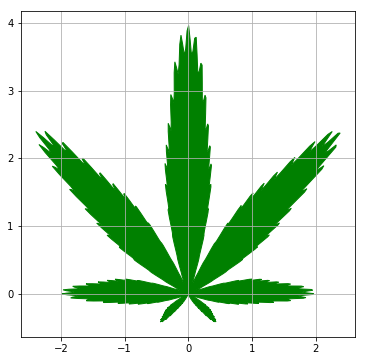

In [5]:
# Run this cell and make sure the plot is correct
plt.figure(figsize=[6,6])
plt.fill(x.numpy(), y.numpy(), color='green')
plt.grid()

## Task 2 (7 points)

Use tensors only: **no lists, loops, numpy arrays etc.**

We will implement [Conway's Game of Life](https://en.wikipedia.org/wiki/Conway's_Game_of_Life) in PyTorch.

![img](https://cdn.tutsplus.com/gamedev/authors/legacy/Stephane%20Beniak/2012/09/11/Preview_Image.png)

If you skipped the URL above, here are the rules:
* You have a 2D grid of cells, where each cell is "alive"(1) or "dead"(0)
* At one step in time, the generation update happens:
  * Any living cell that has 2 or 3 neighbors survives, otherwise (0,1 or 4+ neighbors) it dies
  * Any cell with exactly 3 neighbors becomes alive if it was dead

You are given a reference numpy implementation of the update step. Your task is to convert it to PyTorch.

In [6]:
from scipy.signal import correlate2d as conv2d

def numpy_update(alive_map):
    # Count neighbours with convolution
    conv_kernel = np.array([[1,1,1],
                            [1,0,1],
                            [1,1,1]])
    
    num_alive_neighbors = conv2d(alive_map, conv_kernel, mode='same')
    # Apply game rules
    born = np.logical_and(num_alive_neighbors == 3, alive_map == 0)
    survived = np.logical_and(np.isin(num_alive_neighbors, [2,3]), alive_map == 1)
    np.copyto(alive_map, np.logical_or(born, survived))


In [7]:
def torch_update(alive_map):
    """
    Game of Life update function that does to `alive_map` exactly the same as `numpy_update`.
    
    :param alive_map: `torch.tensor` of shape `(height, width)` and dtype `torch.float32`
        containing 0s (dead) an 1s (alive)
    """
    # Your code here
    conv_kernel = torch.Tensor([[1,1,1],
                                [1,0,1],
                                [1,1,1]])
    conv_kernel = conv_kernel.view(1,1, conv_kernel.size(0), conv_kernel.size(1))
    num_alive_neighbors = torch.conv2d(alive_map.view(1,1, alive_map.size(0), alive_map.size(1)), conv_kernel, padding =1) [0,0,:,:]
    born = torch.eq(num_alive_neighbors,3) & torch.eq(alive_map,0)
    survived =  (torch.eq(num_alive_neighbors,2) | torch.eq(num_alive_neighbors,3)) & torch.eq(alive_map,1)
    torch.add(born.type(torch.FloatTensor),survived.type(torch.FloatTensor), out = alive_map)


In [8]:
# Generate a random initial map
alive_map_numpy = np.random.choice([0, 1], p=(0.5, 0.5), size=(100, 100))
alive_map_torch = torch.tensor(alive_map_numpy).float().clone()

numpy_update(alive_map_numpy)
torch_update(alive_map_torch)

# results should be identical
assert np.allclose(alive_map_torch.numpy(), alive_map_numpy), \
    "Your PyTorch implementation doesn't match numpy_update."
print("Well done!")

Well done!


<IPython.core.display.Javascript object>


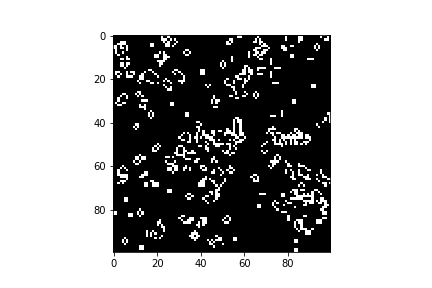

In [ ]:
%matplotlib notebook
plt.ion()

# initialize game field
alive_map = np.random.choice([0, 1], size=(100, 100))
alive_map = torch.tensor(alive_map).float()

fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()

for _ in range(100):
    torch_update(alive_map)
    
    # re-draw image
    ax.clear()
    ax.imshow(alive_map.numpy(), cmap='gray')
    fig.canvas.draw()

In [ ]:
# A fun setup for your amusement
alive_map = np.arange(100) % 2 + np.zeros([100, 100])
alive_map[48:52, 50] = 1

alive_map = torch.tensor(alive_map).float()

fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()

for _ in range(150):
    torch_update(alive_map)
    ax.clear()
    ax.imshow(alive_map.numpy(), cmap='gray')
    fig.canvas.draw()

More fun with Game of Life: [video](https://www.youtube.com/watch?v=C2vgICfQawE)

## Task 3 (30 points)

You have to solve yet another character recognition problem: 10 letters, ~14 000 train samples.

For this, we ask you to build a multilayer perceptron (*i.e. a neural network of linear layers*) from scratch using **low-level** PyTorch interface.

Requirements:
1. at least 82% accuracy
2. at least 2 linear layers
3. use [softmax followed by categorical cross-entropy](https://gombru.github.io/2018/05/23/cross_entropy_loss/)

**You are NOT allowed to use**
* numpy arrays
* `torch.nn`, `torch.optim`
* convolutions

Tips:

* Pick random batches (either shuffle data before each epoch or sample each batch randomly).
* Do not initialize weights with zeros ([learn why](https://stats.stackexchange.com/questions/27112/danger-of-setting-all-initial-weights-to-zero-in-backpropagation)). Gaussian noise with small variance will do.
* 50 hidden neurons and a sigmoid nonlinearity will do for a start. Many ways to improve.
* To improve accuracy, consider changing layers' sizes, nonlinearities, optimization methods, weights initialization.
* Don't use GPU yet.

**Reproducibility requirement**: you have to format your code cells so that `Cell -> Run All` on a fresh notebook **reliably** trains your model to the desired accuracy in a couple of minutes and reports the accuracy reached.

Happy googling!

In [ ]:
np.random.seed(666)
torch.manual_seed(666)

from notmnist import load_notmnist
letters = 'ABCDEFGHIJ' 
X_train, y_train, X_test, y_test = map(torch.tensor, load_notmnist(letters=letters))
X_train.squeeze_()
X_test.squeeze_();

In [ ]:
%matplotlib inline

fig, axarr = plt.subplots(2, 10, figsize=(15,3))

for idx, ax in enumerate(axarr.ravel()):
    ax.imshow(X_train[idx].numpy(), cmap='gray')
    ax.axis('off')
    ax.set_title(letters[y_train[idx]])

The cell below has an example layout for encapsulating your neural network. Feel free to modify the interface if you need to (add arguments, add return values, add methods etc.). For example, you may want to add a method `do_gradient_step()` that executes one optimization algorithm (SGD / Adadelta / Adam / ...) step.

In [ ]:
class NeuralNet:
    def __init__(self):
        # Your code here
        self.input_size = 28*28
        self.output_size = 10
              
        #To be changed
        self.mu = 0
        self.sigma = 0.02
        self.hidden_layer_size = 70 
        self.learning_rate = 2e-2 
        
        #Weights for linear layers
        self.W1 = torch.zeros(self.input_size, self.hidden_layer_size, requires_grad = True)
        self.b1 = torch.zeros(self.hidden_layer_size, requires_grad = True)
        self.W2 = torch.zeros(self.hidden_layer_size, self.output_size, requires_grad = True)
        self.b2 = torch.zeros(self.output_size, requires_grad = True)
        
        self.W1.data.normal_(self.mu,self.sigma)
        self.W2.data.normal_(self.mu,self.sigma)
        self.b1.data.normal_(self.mu,self.sigma)
        self.b2.data.normal_(self.mu,self.sigma)



    def predict(self, images):
        """
        images: `torch.tensor` of shape `batch_size x height x width`
            and dtype `torch.float32`.
        
        returns: `output`, a `torch.tensor` of shape `batch_size x 10`,
            where `output[i][j]` is the probability of `i`-th
            batch sample to belong to `j`-th class.
        """
        # Your code here
        return self.forward(self.reshaped(images))
    
    
    # Your code here
    def reshaped(self, images):
        return  images.reshape([images.size(0), -1])
                            
    def forward(self, images):
        #linear -> sigmoid -> linear -> softmax 
        output = images.clone()
        mult_in = torch.matmul(output,self.W1)
        output = torch.sigmoid(torch.add(mult_in,self.b1))
        mult_out = torch.matmul(output,self.W2)
        return torch.softmax(torch.add(mult_out,self.b2), dim = 1)
        
        
    def do_gradient_step(self):
        l_r = self.learning_rate
        self.W1.data -= l_r * self.W1.grad.data
        self.b1.data -= l_r * self.b1.grad.data
        self.W2.data -= l_r * self.W2.grad.data
        self.b2.data -= l_r * self.b2.grad.data
        
        self.W1.grad = torch.zeros_like(self.W1)
        self.W2.grad = torch.zeros_like(self.W2)
        self.b1.grad = torch.zeros_like(self.b1)
        self.b2.grad = torch.zeros_like(self.b2)
        
    def loss(self, predicted, labels):
        return - torch.sum(labels * torch.log(predicted)) / labels.size(0)


In [ ]:
def accuracy(model, images, labels):
    """
    model: `NeuralNet`
    images: `torch.tensor` of shape `N x height x width`
        and dtype `torch.float32`
    labels: `torch.tensor` of shape `N` and dtype `torch.int64`. Contains
        class index for each sample
    
    returns:
        fraction of samples from `images` correctly classified by `model`
    """
    # Your code here
    pred_probs = model.predict(images)
    pred_labels = torch.argmax(pred_probs, dim = 1)
    output = float(torch.sum(pred_labels == labels))
    return output / labels.size(0)

def get_batches(X,y, batch_size):
    n_samples = X.size(0)
    indices = torch.randperm(n_samples)
    batch = torch.split(indices, batch_size)
    for batch_idx in batch:
        yield X[batch_idx], y[batch_idx]


In [ ]:
# model = NeuralNet()
from tqdm import tqdm
model = NeuralNet()
# Your code here (train the model)
n_epoch = 500
batch_size = 2000
for i in tqdm(range(n_epoch)):
    for X_batch, y_batch in get_batches(X_train, y_train, batch_size):
        y_batch_one_hot = torch.eye(10)[y_batch]
        predicted = model.predict(X_batch)
        losses = model.loss(predicted,y_batch_one_hot)
        losses.backward()
        model.do_gradient_step()
    


        


In [ ]:
train_acc = accuracy(model, X_train, y_train) * 100
test_acc = accuracy(model, X_test, y_test) * 100
print("Train accuracy: %.2f, test accuracy: %.2f" % (train_acc, test_acc))

assert test_acc >= 82.0, "You have to do better"